In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy
import cmath
# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port, N_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 1.55e-6                   #波长       
c0 = 3e8                            #真空中光速
omega = 2*np.pi*c0/lambda0         #角频率
dl = 0.5e-1                        #网格单元长度
NPML = [20, 20]                    # the actral simulation size
pol = 'Ez'                         # the excit source is Ez
source_amp = 1e-9 

n_index = 3.475 
eps_m = 11.70                      #just n_index^2

Computed a domain with 400 grids in x and 280 grids in y
The simulation has 30 grids per free space wavelength


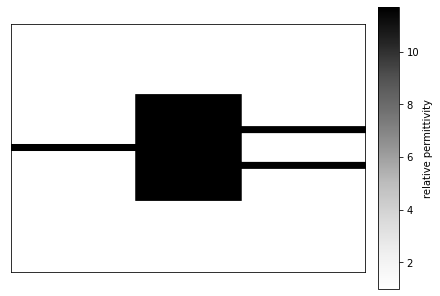

In [3]:
# call the inbuilt function and define the geometry
N = 2
L = 6
H = 6
w = 0.4 #um
d = 2  
l = 6
spc = 3                            #??????

eps_r, design_region = N_port(N, L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)
simulation1 = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation1.L0)))

simulation1.plt_eps(outline=False)
plt.show()

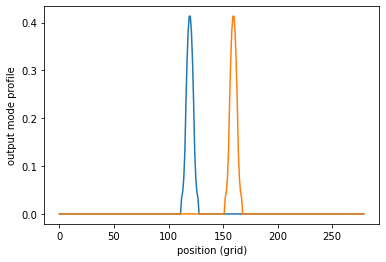

In [4]:
# add simulaiton mode for input waveguide
simulation1.add_mode(neff=n_index, direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale= 1 *source_amp)
simulation1.setup_modes()


J_list1 = [] # I think J_list1 is the list of all mode field for the output waveguides

for i in range(N):
    sim_tmp1 = Simulation(omega, eps_r, dl, NPML, 'Ez')
    y1 = (float(i)-float(N-1)/2.0)*d
    y_index1 = int(y1/dl + ny)
#add simulation mode for output waveguide
    sim_tmp1.add_mode(neff=n_index, direction_normal='x', center=[-NPML[0]-int(l/2/dl), y_index1], width=int(2*w/dl))
    sim_tmp1.setup_modes()
# set value to the J_list
    J_tmp1 = np.abs(sim_tmp1.src)
    J_list1.append(J_tmp1)
    plt.plot(J_tmp1[-NPML[0]-int(l/2/dl), :])
plt.xlabel('position (grid)')
plt.ylabel('output mode profile')
plt.show()

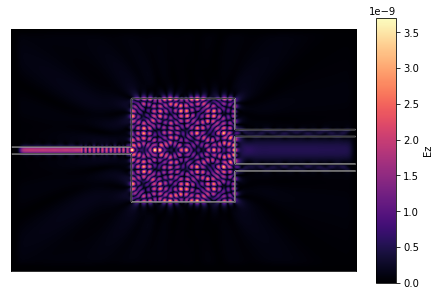

In [5]:
(Hx, Hy, Ez) = simulation1.solve_fields()
simulation1.plt_abs(outline=True, cbar=True);

computed a scale of (-9.629692856170677e-10+3.020590664637698e-09j)


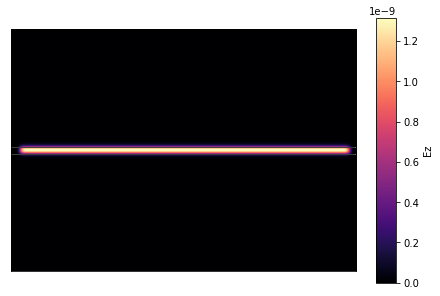

In [6]:
# Normalization
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(n_index, 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(n_index, 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()

SCALE = np.sum(Ez_wg*J_out)
J_out = J_out
print('computed a scale of {}'.format(SCALE))

simulation_wg.plt_abs(outline=True, cbar=True);

for i in range(N):
    J_list1[i] = J_list1[i] / np.abs(SCALE)

In [7]:
np.abs(SCALE)

3.170375026450066e-09

In [8]:
J_list1

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

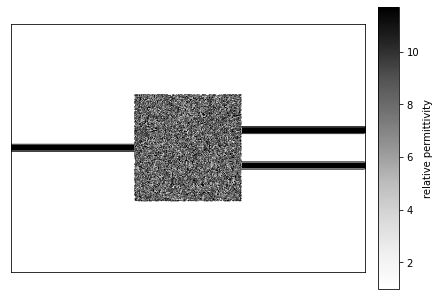

In [12]:
# Begin the optimization
simulation1.init_design_region(design_region, eps_m, style='random')
simulation1.plt_eps(outline=True)
plt.show()

import autograd.numpy as npa
from angler.objective import Objective, obj_arg

arg1 = obj_arg('ez', component='Ez', nl=False)

# define the desired output
Mi = [0.3+0.5j, 0.7-0.2j]
MSUM = np.sum(np.abs(Mi))


#define the objective function
def J(ez):
    ERRSUM = 0
    for i in range(N):
        transmit_i = npa.sum(ez*J_list1[i])
        ERRSUM += npa.abs(transmit_i - Mi[i])
    objfn = 1 - ERRSUM
    return objfn
        
objective = Objective(J, arg_list=[arg1])

R = 5
beta = 500  
eta = 0.50    

In [13]:
optimization = Optimization(objective=objective, simulation=simulation1, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

 99% (347 of 349) |##################### | Elapsed Time: 0:01:42 ETA:   0:00:00

adjoint gradient   = [-0.03189729154798748, -0.007234383191625816, -0.030642228668571872, 0.005690413051975407, 0.014350606878630044]
numerical gradient = [-0.031848645199783476, -0.007189039896715599, -0.030760619327274696, 0.005696127265863993, 0.014373790296673405]


 ObjectiveFn:      1 Iteration:  169/800 ETA:   7:03:20                        

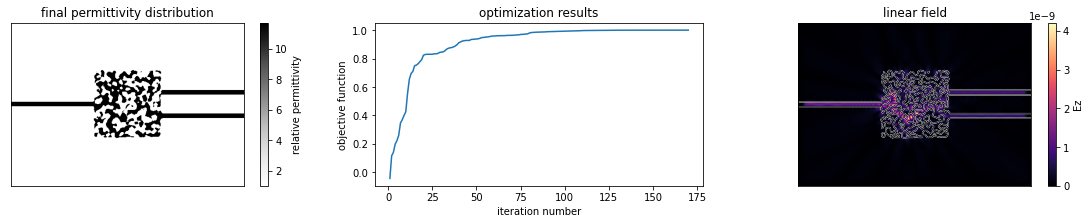

In [14]:
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))
new_eps = optimization.run(method='lbfgs', Nsteps=800)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation1.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation1.solve_fields()
simulation1.plt_abs(ax=ax3, vmax=None)
ax3.set_title('linear field')

plt.show()

In [15]:
 #plot transmission characteristics

(_, _, ez) = simulation1.solve_fields()

OUTPUT = np.zeros(N,dtype="complex128")
OUTPUT_MSUM = np.zeros(N,dtype="complex128")
for i in range(N):
#     OUTPUT[i] = npa.sum(ez*J_list1[i])
   OUTPUT[i] =npa.sum(ez*J_list1[i]) #real value number
print('通过结构优化并归一化后的输出OUTPUT:','\n',OUTPUT)
print('\n')

for j in range(N):
    OUTPUT_MSUM[j] = OUTPUT[j] * MSUM
print('not nomalized输出的OUTPUT:','\n',OUTPUT_MSUM)
print('\n')

print('期望输出的OUTPUT:','\n',Mi)

通过结构优化并归一化后的输出OUTPUT: 
 [0.3+0.5j 0.7-0.2j]


not nomalized输出的OUTPUT: 
 [0.39333185+0.65555309j 0.91777432-0.26222124j]


期望输出的OUTPUT: 
 [(0.3+0.5j), (0.7-0.2j)]


Text(0.5, 1.0, 'linear field')

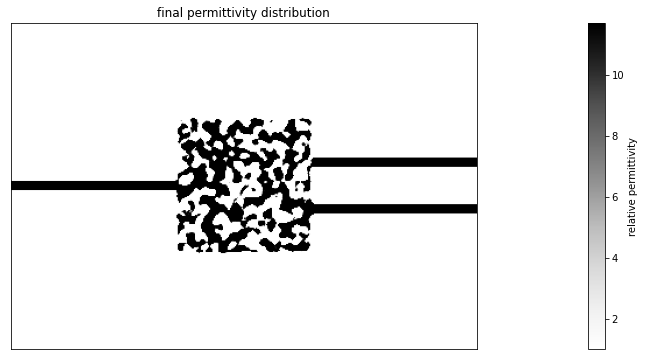

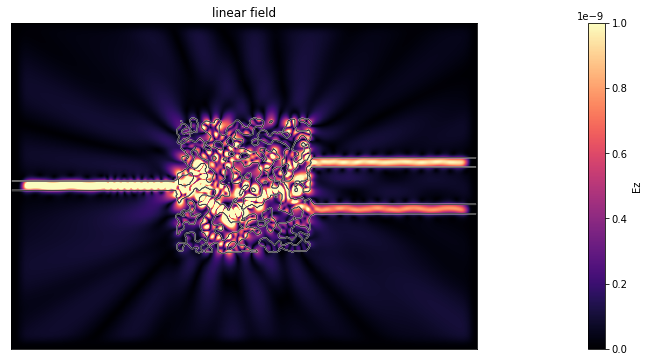

In [16]:
f, (ax1) = plt.subplots(1, 1, figsize=(40,6))

simulation1.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

f, (ax3) = plt.subplots(1, 1, figsize=(40,6))
(_,_,Ez) = simulation1.solve_fields()
simulation1.plt_abs(ax=ax3, vmax=1e-9)
ax3.set_title('linear field')